First we need to import utils package and tensorflow with addons.

In [1]:
from utils import *
import tensorflow as tf
import tensorflow_addons as tfa

set_seed(42)

/home/vojta/tf/lib/python3.6/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.3.0 and strictly below 2.5.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.5.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


Next, we define our model. Note that reparametrization trick is done manually - it can be done with tensorflow probability package, which is doing that by itself automatically.

In [2]:
class DiagonalToZero(tf.keras.constraints.Constraint):
    def __call__(self, w):
        """Set diagonal to zero"""
        q = tf.linalg.set_diag(w, tf.zeros(w.shape[0:-1]), name=None)
        return q

class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a basket."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim), stddev=1.)
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VASP(Model):
    class Model(tf.keras.Model):
        def __init__(self, num_words, latent=1024, hidden=1024, items_sampling=1.):
            """
            num_words             nr of items in dataset (size of tokenizer)
            latent                size of latent space
            hidden                size of hidden layers
            items_sampling        Large items datatsets can be very gpu memory consuming in EASE layer.
                                  This coefficient reduces number of ease parametrs by taking only
                                  fraction of items sorted by popularity as input for model.
                                  Note: This coef should be somewhere around coverage@100 achieved by full
                                  size model.
                                  For ML20M this coef should be between 0.4888 (coverage@100 for full model)
                                  and 1.0
                                  For Netflix this coef should be between 0.7055 (coverage@100 for full
                                  model) and 1.0
            """
            super(VASP.Model, self).__init__()

            self.sampled_items = int(num_words * items_sampling)

            assert self.sampled_items > 0
            assert self.sampled_items <= num_words

            self.s = self.sampled_items < num_words

            # ************* ENCODER ***********************
            self.encoder1 = tf.keras.layers.Dense(hidden)
            self.ln1 = tf.keras.layers.LayerNormalization()
            self.encoder2 = tf.keras.layers.Dense(hidden)
            self.ln2 = tf.keras.layers.LayerNormalization()
            self.encoder3 = tf.keras.layers.Dense(hidden)
            self.ln3 = tf.keras.layers.LayerNormalization()
            self.encoder4 = tf.keras.layers.Dense(hidden)
            self.ln4 = tf.keras.layers.LayerNormalization()
            self.encoder5 = tf.keras.layers.Dense(hidden)
            self.ln5 = tf.keras.layers.LayerNormalization()
            self.encoder6 = tf.keras.layers.Dense(hidden)
            self.ln6 = tf.keras.layers.LayerNormalization()
            self.encoder7 = tf.keras.layers.Dense(hidden)
            self.ln7 = tf.keras.layers.LayerNormalization()

            # ************* SAMPLING **********************
            self.dense_mean = tf.keras.layers.Dense(latent,
                                                    name="Mean")
            self.dense_log_var = tf.keras.layers.Dense(latent,
                                                       name="log_var")

            self.sampling = Sampling(name='Sampler')

            # ************* DECODER ***********************
            self.decoder1 = tf.keras.layers.Dense(hidden)
            self.dln1 = tf.keras.layers.LayerNormalization()
            self.decoder2 = tf.keras.layers.Dense(hidden)
            self.dln2 = tf.keras.layers.LayerNormalization()
            self.decoder3 = tf.keras.layers.Dense(hidden)
            self.dln3 = tf.keras.layers.LayerNormalization()
            self.decoder4 = tf.keras.layers.Dense(hidden)
            self.dln4 = tf.keras.layers.LayerNormalization()
            self.decoder5 = tf.keras.layers.Dense(hidden)
            self.dln5 = tf.keras.layers.LayerNormalization()

            self.decoder_resnet = tf.keras.layers.Dense(self.sampled_items,
                                                        activation='sigmoid',
                                                        name="DecoderR")
            self.decoder_latent = tf.keras.layers.Dense(self.sampled_items,
                                                        activation='sigmoid',
                                                        name="DecoderL")

            # ************* PARALLEL SHALLOW PATH *********

            self.ease = tf.keras.layers.Dense(
                self.sampled_items,
                activation='sigmoid',
                use_bias=False,
                kernel_constraint=DiagonalToZero(),  # critical to prevent learning simple identity
            )

        def call(self, x, training=None):
            sampling = self.s
            if sampling:
                sampled_x = x[:, :self.sampled_items]
                non_sampled = x[:, self.sampled_items:] * 0.
            else:
                sampled_x = x

            z_mean, z_log_var, z = self.encode(sampled_x)
            if training:
                d = self.decode(z)
                # Add KL divergence regularization loss.
                kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
                kl_loss = tf.reduce_mean(kl_loss)
                kl_loss *= -0.5
                self.add_loss(kl_loss)
                self.add_metric(kl_loss, name="kl_div")
            else:
                d = self.decode(z_mean)

            if sampling:
                d = tf.concat([d, non_sampled], axis=-1)

            ease = self.ease(sampled_x)

            if sampling:
                ease = tf.concat([ease, non_sampled], axis=-1)

            return d * ease

        def decode(self, x):
            e0 = x
            e1 = self.dln1(tf.keras.activations.swish(self.decoder1(e0)))
            e2 = self.dln2(tf.keras.activations.swish(self.decoder2(e1) + e1))
            e3 = self.dln3(tf.keras.activations.swish(self.decoder3(e2) + e1 + e2))
            e4 = self.dln4(tf.keras.activations.swish(self.decoder4(e3) + e1 + e2 + e3))
            e5 = self.dln5(tf.keras.activations.swish(self.decoder5(e4) + e1 + e2 + e3 + e4))

            dr = self.decoder_resnet(e5)
            dl = self.decoder_latent(x)

            return dr * dl

        def encode(self, x):
            e0 = x
            e1 = self.ln1(tf.keras.activations.swish(self.encoder1(e0)))
            e2 = self.ln2(tf.keras.activations.swish(self.encoder2(e1) + e1))
            e3 = self.ln3(tf.keras.activations.swish(self.encoder3(e2) + e1 + e2))
            e4 = self.ln4(tf.keras.activations.swish(self.encoder4(e3) + e1 + e2 + e3))
            e5 = self.ln5(tf.keras.activations.swish(self.encoder5(e4) + e1 + e2 + e3 + e4))
            e6 = self.ln6(tf.keras.activations.swish(self.encoder6(e5) + e1 + e2 + e3 + e4 + e5))
            e7 = self.ln7(tf.keras.activations.swish(self.encoder7(e6) + e1 + e2 + e3 + e4 + e5 + e6))

            z_mean = self.dense_mean(e7)
            z_log_var = self.dense_log_var(e7)
            z = self.sampling((z_mean, z_log_var))

            return z_mean, z_log_var, z

    def create_model(self, latent=2048, hidden=4096, ease_items_sampling=1., summary=False):
        self.model = VASP.Model(self.dataset.num_words, latent, hidden, ease_items_sampling)
        self.model(self.split.train_gen[0][0])
        if summary:
            self.model.summary()
        self.mc = MetricsCallback(self)

    def compile_model(self, lr=0.00002, fl_alpha=0.25, fl_gamma=2.0):
        """
        lr         learning rate of Nadam optimizer
        fl_alpha   alpha parameter of focal crossentropy
        fl_gamma   gamma parameter of focal crossentropy
        """
        self.model.compile(
            optimizer=tf.keras.optimizers.Nadam(lr),
            loss=lambda x, y: tfa.losses.sigmoid_focal_crossentropy(x, y, alpha=fl_alpha, gamma=fl_gamma),
            metrics=['mse', cosine_loss]
        )

    def train_model(self, epochs=150):
        self.model.fit(
            self.split.train_gen,
            validation_data=self.split.validation_gen,
            epochs=epochs,
            callbacks=[self.mc]
        )



Now, we can load previously preprocessed dataset. We also load pre-defined train/test/validation split.

In [3]:
dataset = Data(d='', pruning='u5')
dataset.splits = []
dataset.create_splits(1, 10000, shuffle=False, generators=False)
dataset.split.train_users = pd.read_json("train_users.json").userid.apply(str).to_frame()
dataset.split.validation_users = pd.read_json("val_users.json").userid.apply(str).to_frame()
dataset.split.test_users = pd.read_json("test_users.json").userid.apply(str).to_frame()
dataset.split.generators()

Reading users_pu5
Reading items_pu5
Reading purchases_txt_pu5
Reading items_sorted_pu5
Reading users_sorted_pu5
Read all in 0.6187641620635986
Tokenizer trained for 20721 items.
Creating 1 splits of 10000 samples each.
Creating split nr. 1
SplitGenerator init done in 4.510331630706787 secs.
SplitGenerator init done in 0.38019323348999023 secs.
SplitGenerator init done in 0.3815438747406006 secs.
Creating evaluator
Creating test split evaluator with leave_random_20_pct_out method.
Creating validation split evaluator with leave_random_20_pct_out method.


Now we can create an instance of our model and train it.

For validation during training we sample 80% of the user's interactions randomly as input for the model, and then we measure Recall@20, Recall@50 and NDCG@100 for predicted interactions against the remaining 20% of the user's interactions.

This method can give different results for different seeds, but since it is used for validation during training only, it's good enough.

In [4]:
m = VASP(dataset.split, name="VASP_ML20_1")
m.create_model(latent=2048, hidden=4096, ease_items_sampling=0.33)
m.model.summary()
print("=" * 80)
print("Train for 50 epochs with lr 0.00005")
m.compile_model(lr=0.00005, fl_alpha=0.25, fl_gamma=2.0)
m.train_model(50)
print("=" * 80)
print("Than train for 20 epochs with lr 0.00001")
m.compile_model(lr=0.00001, fl_alpha=0.25, fl_gamma=2.0)
m.train_model(20)
print("=" * 80)
print("Than train for 20 epochs with lr 0.000001")
m.compile_model(lr=0.00001, fl_alpha=0.25, fl_gamma=2.0)
m.train_model(20)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  28008448  
_________________________________________________________________
layer_normalization (LayerNo multiple                  8192      
_________________________________________________________________
dense_1 (Dense)              multiple                  16781312  
_________________________________________________________________
layer_normalization_1 (Layer multiple                  8192      
_________________________________________________________________
dense_2 (Dense)              multiple                  16781312  
_________________________________________________________________
layer_normalization_2 (Layer multiple                  8192      
_________________________________________________________________
dense_3 (Dense)              multiple                  167813

Model metrics:Recall@5=0.3094 Recall@20=0.3769 Recall@50=0.5056 NCDG@100=0.4056 Coverage@5=0.0575 Coverage@20=0.1078 Coverage@50=0.1553 Coverage@100=0.1984 
New best for NCDG@100
New best for Recall@20
New best for Recall@50
Epoch 10/50
112/112 [==============================] - 52s 462ms/step - loss: 14.3444 - mse: 0.0021 - cosine_loss: 0.7555 - kl_div: 0.2901 - val_loss: 23.5730 - val_mse: 0.0034 - val_cosine_loss: 0.7021 - val_kl_div: 0.0000e+00
Model metrics:Recall@5=0.3111 Recall@20=0.3792 Recall@50=0.5092 NCDG@100=0.4087 Coverage@5=0.0613 Coverage@20=0.1158 Coverage@50=0.1631 Coverage@100=0.2077 
New best for NCDG@100
New best for Recall@20
New best for Recall@50
Epoch 11/50
112/112 [==============================] - 52s 463ms/step - loss: 14.2561 - mse: 0.0021 - cosine_loss: 0.7532 - kl_div: 0.2878 - val_loss: 23.7708 - val_mse: 0.0035 - val_cosine_loss: 0.7046 - val_kl_div: 0.0000e+00
Model metrics:Recall@5=0.3124 Recall@20=0.3809 Recall@50=0.5113 NCDG@100=0.4094 Coverage@5=0.0

New best for Recall@20
New best for Recall@50
Epoch 28/50
112/112 [==============================] - 53s 467ms/step - loss: 13.3059 - mse: 0.0019 - cosine_loss: 0.7258 - kl_div: 0.3085 - val_loss: 28.7310 - val_mse: 0.0036 - val_cosine_loss: 0.7534 - val_kl_div: 0.0000e+00
Model metrics:Recall@5=0.3325 Recall@20=0.4042 Recall@50=0.5377 NCDG@100=0.4343 Coverage@5=0.0669 Coverage@20=0.1429 Coverage@50=0.2103 Coverage@100=0.262 
New best for NCDG@100
New best for Recall@20
New best for Recall@50
Epoch 29/50
112/112 [==============================] - 52s 465ms/step - loss: 13.2743 - mse: 0.0019 - cosine_loss: 0.7247 - kl_div: 0.3101 - val_loss: 28.4764 - val_mse: 0.0035 - val_cosine_loss: 0.7457 - val_kl_div: 0.0000e+00
Model metrics:Recall@5=0.3338 Recall@20=0.4025 Recall@50=0.5379 NCDG@100=0.4339 Coverage@5=0.0582 Coverage@20=0.132 Coverage@50=0.1978 Coverage@100=0.2506 
New best for Recall@50
Epoch 30/50
112/112 [==============================] - 52s 464ms/step - loss: 13.2314 - mse: 0.

112/112 [==============================] - 53s 467ms/step - loss: 12.6027 - mse: 0.0018 - cosine_loss: 0.7054 - kl_div: 0.3566 - val_loss: 34.7518 - val_mse: 0.0037 - val_cosine_loss: 0.7968 - val_kl_div: 0.0000e+00
Model metrics:Recall@5=0.3413 Recall@20=0.4107 Recall@50=0.548 NCDG@100=0.4403 Coverage@5=0.0686 Coverage@20=0.1475 Coverage@50=0.2226 Coverage@100=0.2763 
Epoch 48/50
112/112 [==============================] - 52s 465ms/step - loss: 12.5745 - mse: 0.0018 - cosine_loss: 0.7045 - kl_div: 0.3599 - val_loss: 33.9941 - val_mse: 0.0036 - val_cosine_loss: 0.7889 - val_kl_div: 0.0000e+00
Model metrics:Recall@5=0.3405 Recall@20=0.4108 Recall@50=0.5484 NCDG@100=0.4414 Coverage@5=0.0654 Coverage@20=0.1432 Coverage@50=0.2173 Coverage@100=0.2725 
New best for NCDG@100
New best for Recall@50
Epoch 49/50
112/112 [==============================] - 52s 466ms/step - loss: 12.5371 - mse: 0.0018 - cosine_loss: 0.7036 - kl_div: 0.3624 - val_loss: 33.7738 - val_mse: 0.0036 - val_cosine_loss: 0.

Epoch 17/20
112/112 [==============================] - 53s 470ms/step - loss: 12.2637 - mse: 0.0018 - cosine_loss: 0.6953 - kl_div: 0.3804 - val_loss: 37.2010 - val_mse: 0.0038 - val_cosine_loss: 0.8139 - val_kl_div: 0.0000e+00
Model metrics:Recall@5=0.3423 Recall@20=0.4139 Recall@50=0.5491 NCDG@100=0.4427 Coverage@5=0.0726 Coverage@20=0.155 Coverage@50=0.2305 Coverage@100=0.2849 
Epoch 18/20
112/112 [==============================] - 53s 470ms/step - loss: 12.2664 - mse: 0.0018 - cosine_loss: 0.6950 - kl_div: 0.3814 - val_loss: 37.1380 - val_mse: 0.0038 - val_cosine_loss: 0.8136 - val_kl_div: 0.0000e+00
Model metrics:Recall@5=0.3429 Recall@20=0.4133 Recall@50=0.5498 NCDG@100=0.4431 Coverage@5=0.0721 Coverage@20=0.1544 Coverage@50=0.2298 Coverage@100=0.2844 
New best for Recall@50
Epoch 19/20
112/112 [==============================] - 53s 469ms/step - loss: 12.2494 - mse: 0.0018 - cosine_loss: 0.6949 - kl_div: 0.3817 - val_loss: 37.3311 - val_mse: 0.0038 - val_cosine_loss: 0.8151 - val

Epoch 18/20
112/112 [==============================] - 53s 469ms/step - loss: 12.1240 - mse: 0.0017 - cosine_loss: 0.6905 - kl_div: 0.3945 - val_loss: 38.4368 - val_mse: 0.0038 - val_cosine_loss: 0.8230 - val_kl_div: 0.0000e+00
Model metrics:Recall@5=0.3433 Recall@20=0.4143 Recall@50=0.5492 NCDG@100=0.4429 Coverage@5=0.0739 Coverage@20=0.159 Coverage@50=0.2347 Coverage@100=0.2889 
Epoch 19/20
112/112 [==============================] - 53s 468ms/step - loss: 12.1110 - mse: 0.0017 - cosine_loss: 0.6903 - kl_div: 0.3953 - val_loss: 38.3934 - val_mse: 0.0038 - val_cosine_loss: 0.8223 - val_kl_div: 0.0000e+00
Model metrics:Recall@5=0.3434 Recall@20=0.4143 Recall@50=0.5496 NCDG@100=0.4428 Coverage@5=0.0741 Coverage@20=0.1582 Coverage@50=0.2342 Coverage@100=0.2884 
Epoch 20/20
112/112 [==============================] - 53s 470ms/step - loss: 12.1050 - mse: 0.0017 - cosine_loss: 0.6902 - kl_div: 0.3956 - val_loss: 38.4890 - val_mse: 0.0038 - val_cosine_loss: 0.8227 - val_kl_div: 0.0000e+00
Mod

Dataframe with the details of the training.

In [5]:
m.mc.get_history_df()

,epochs,Recall@5,Recall@20,Recall@50,NCDG@100,Coverage@5,Coverage@20,Coverage@50,Coverage@100
0,1,0.225248,0.294548,0.413444,0.320735,0.024759,0.046815,0.070319,0.095512
1,2,0.258408,0.325344,0.449308,0.353952,0.034122,0.062114,0.089382,0.118629
2,3,0.273252,0.341864,0.466868,0.370423,0.043774,0.078137,0.111680,0.144015
3,4,0.283258,0.351177,0.478038,0.380333,0.048986,0.087838,0.124710,0.161245
4,5,0.291767,0.357772,0.485802,0.388339,0.048697,0.087597,0.127606,0.165637
...,...,...,...,...,...,...,...,...,...
85,86,0.343700,0.414246,0.550098,0.443123,0.073311,0.158060,0.233639,0.287741
86,87,0.343230,0.414056,0.549911,0.442972,0.074807,0.159073,0.234459,0.288900
87,88,0.343283,0.414261,0.549162,0.442885,0.073938,0.158977,0.234653,0.288900
88,89,0.343450,0.414298,0.549576,0.442799,0.074131,0.158156,0.234170,0.288417


And the details of the training as a plot.

<AxesSubplot:xlabel='epochs'>

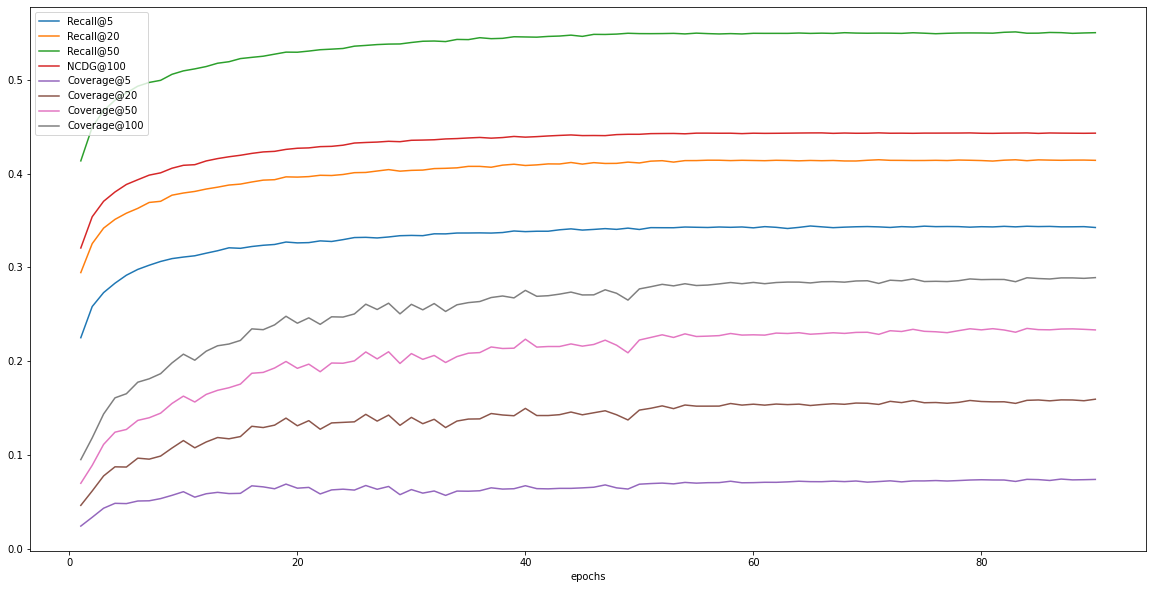

In [6]:
m.mc.plot_history()

For final evaluation we do 5-fold validation on the user's interaction history. We think that this is more objective measure than only hide sampled 20% of the user's interactions randomly.

In [7]:
# 5-fold evaluation on the test set

test_r20s = []
test_r50s = []
test_n100s = []

for fold in range(1,6):
    ev=Evaluator(m.split, method=str(fold)+'_20')
    ev.update(m.model)

    test_n100s.append(ev.get_ncdg(100))
    test_r20s.append(ev.get_recall(20))
    test_r50s.append(ev.get_recall(50))

print("TEST SET (MEAN)")
print("5-fold mean NCDG@100", round(sum(test_n100s) / len(test_n100s),3))
print("5-fold mean Recall@20", round(sum(test_r20s) / len(test_r20s),3))
print("5-fold mean Recall@50", round(sum(test_r50s) / len(test_r50s),3))

Creating test split evaluator with 1_20 method.
Creating test split evaluator with 2_20 method.
Creating test split evaluator with 3_20 method.
Creating test split evaluator with 4_20 method.
Creating test split evaluator with 5_20 method.
TEST SET (MEAN)
5-fold mean NCDG@100 0.448
5-fold mean Recall@20 0.414
5-fold mean Recall@50 0.552
